In [453]:
import argparse
import yaml
import torch.backends.cudnn as cudnn
import torch
from PIL import Image
import numpy as np
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage, ToTensor
import torchvision.transforms.functional as TF

from util import trainer_util, metrics
from util.iter_counter import IterationCounter
from models.dissimilarity_model import DissimNet, GuidedDissimNet, ResNetDissimNet, CorrelatedDissimNet
from util import visualization

In [467]:
# input parameters
config_file_path = 'configs/visualization/default_configuration.yaml'
gpu_ids = '15'
how_many = 100
#dataroot = '/home/giancarlo/data/innosuisse/fs_lost_and_found'
dataroot = '/home/giancarlo/data/innosuisse/fs_static'
#dataroot = '/home/giancarlo/data/innosuisse/road_anomaly'
#dataroot = '/home/giancarlo/data/innosuisse/epfl/train'
#dataroot = '/home/giancarlo/data/innosuisse/epfl/val'
#dataroot = '/home/giancarlo/data/innosuisse/custom'
#dataroot = '/home/giancarlo/data/innosuisse/custom_val'
#dataroot = '/home/giancarlo/data/innosuisse/mapi/val'
#dataroot = '/home/giancarlo/data/innosuisse/custom_both'
#dataroot = '/home/giancarlo/data/innosuisse/custom_all'
#dataroot = '/home/giancarlo/data/innosuisse/custom_dynamic_epfl'
#dataroot = '/home/giancarlo/data/innosuisse/wild_dash'
#dataroot = '/home/giancarlo/data/innosuisse/visualization_imgs'

In [468]:
# load experiment setting
with open(config_file_path, 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

In [469]:
# get experiment information
exp_name = config['experiment_name']
save_fdr = config['save_folder']
epoch = config['which_epoch']

In [470]:
# activate GPUs
config['gpu_ids'] = gpu_ids
gpu_info = trainer_util.activate_gpus(config)

In [471]:
# get model
if 'vgg' in config['model']['architecture'] and 'guided' in config['model']['architecture']:
    diss_model = GuidedDissimNet(**config['model']).cuda()
if 'vgg' in config['model']['architecture'] and 'correlated' in config['model']['architecture']:
    diss_model = CorrelatedDissimNet(**config['model']).cuda()
elif 'vgg' in config['model']['architecture']:
    diss_model = DissimNet(**config['model']).cuda()
elif 'resnet' in config['model']['architecture']:
    diss_model = ResNetDissimNet(**config['model']).cuda()
else:
    raise NotImplementedError()

In [472]:
# get model weights
diss_model.eval()
model_path = os.path.join(save_fdr, exp_name, '%s_net_%s.pth' %(epoch, exp_name))
model_weights = torch.load(model_path)
diss_model.load_state_dict(model_weights,  strict=False)
# NOTE: For old models, there were some correlation weights created that were not used in the foward pass. That's the reason to include strict=False

<All keys matched successfully>

In [473]:
# neccesary functions
softmax = torch.nn.Softmax(dim=1)
to_pil = ToPILImage()

In [474]:
# get data_loaders
cfg_test_loader = config['test_dataloader']
cfg_test_loader['dataset_args']['dataroot'] = dataroot
test_loader = trainer_util.get_dataloader(cfg_test_loader['dataset_args'], cfg_test_loader['dataloader_args'])
batch_size = cfg_test_loader['dataloader_args']['batch_size']

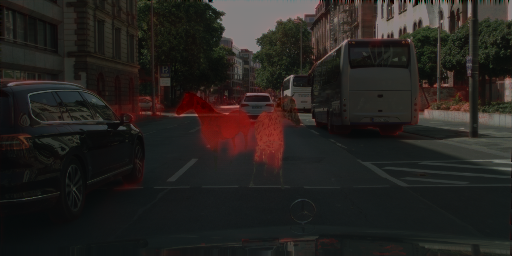

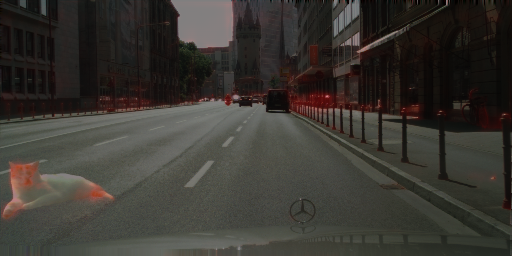

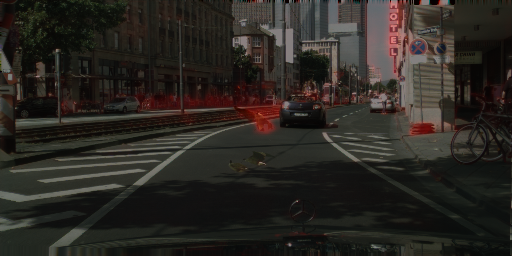

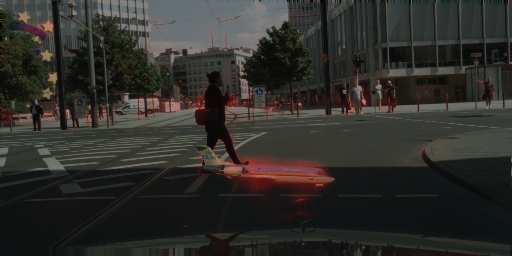

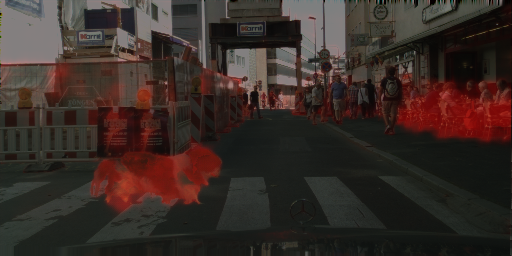

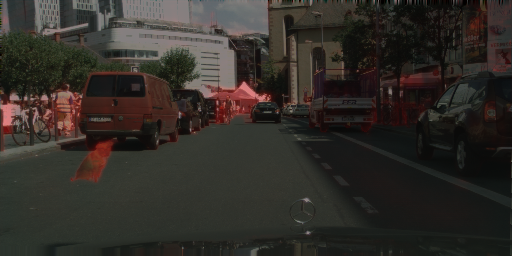

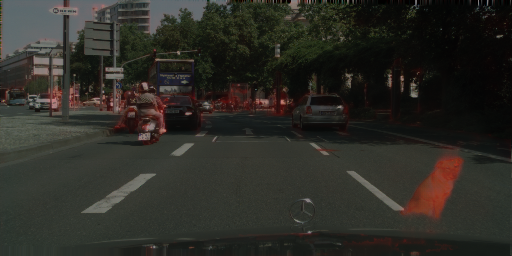

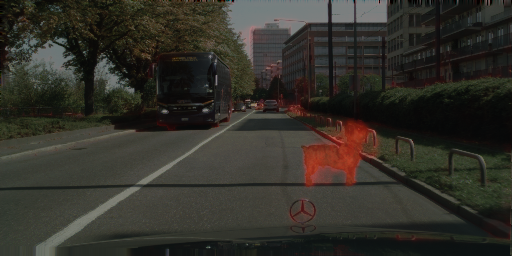

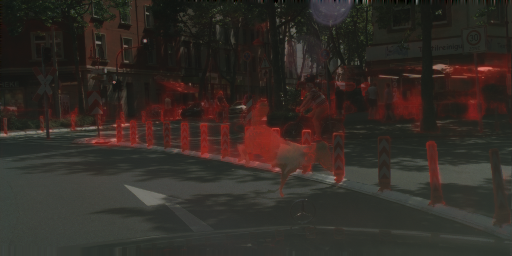

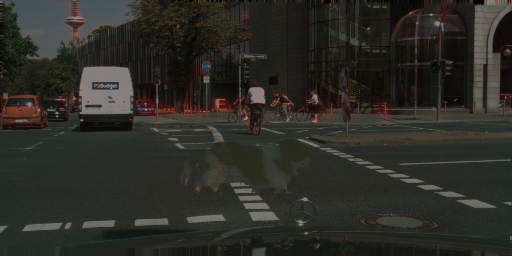

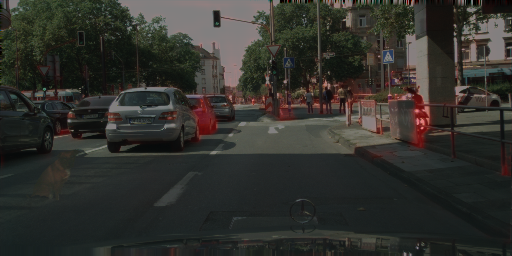

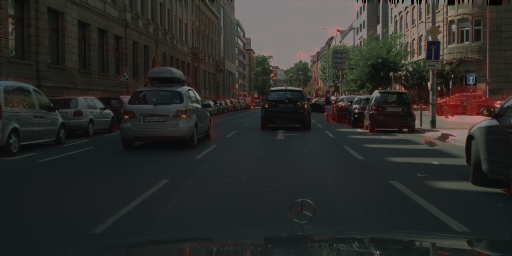

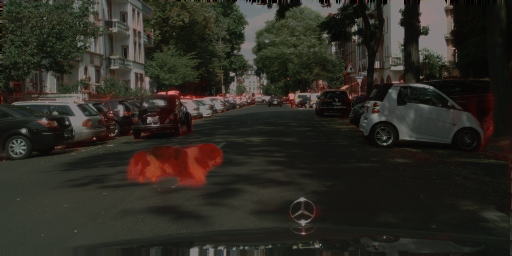

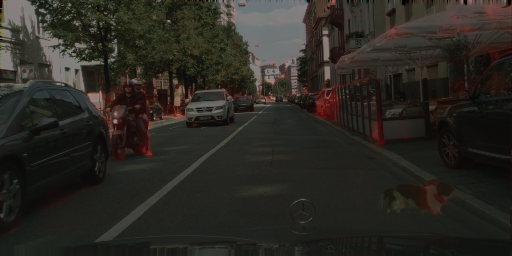

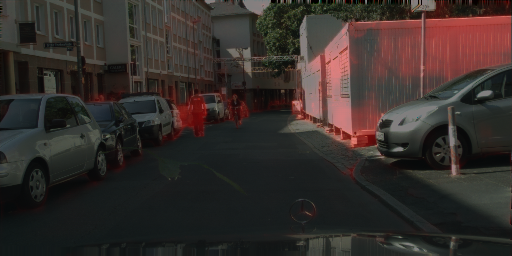

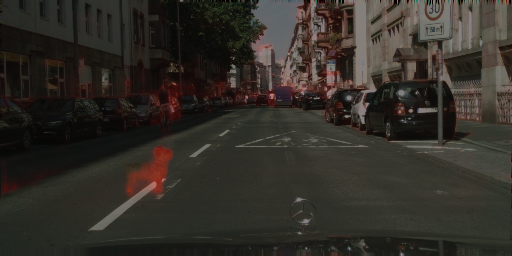

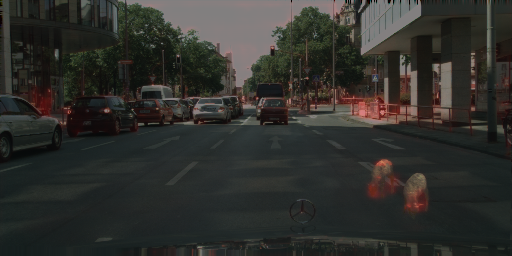

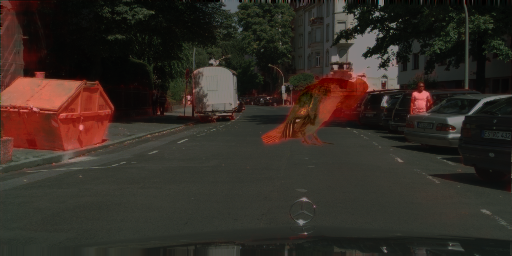

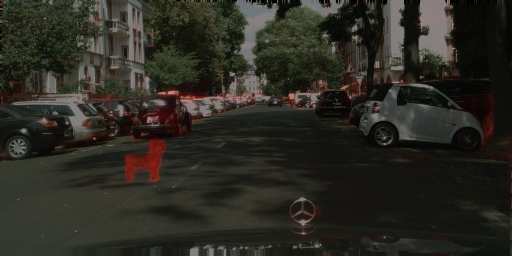

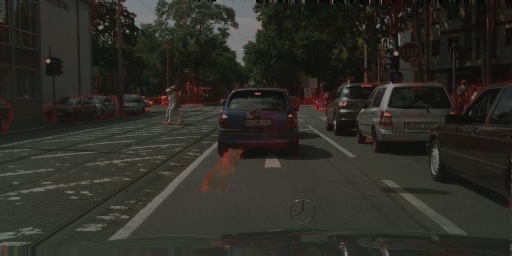

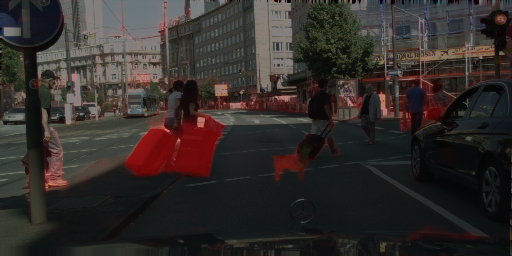

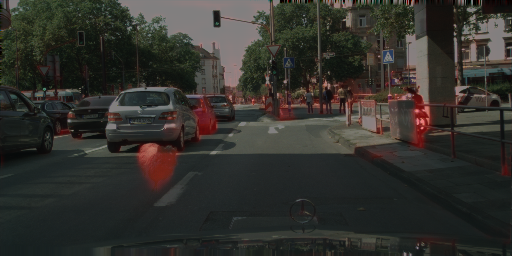

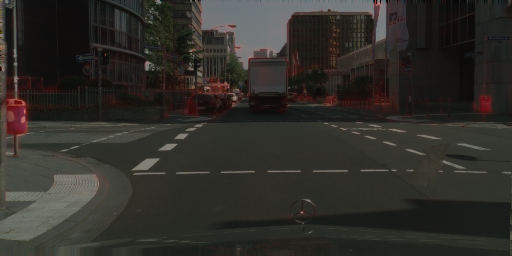

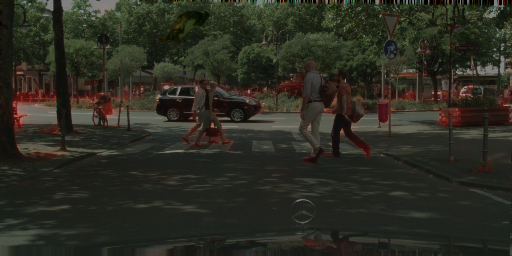

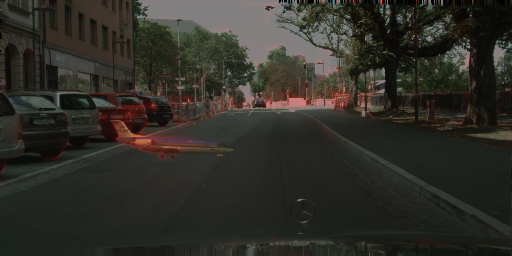

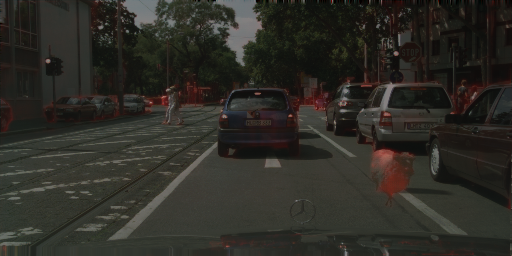

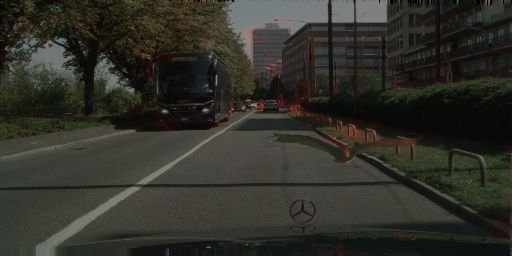

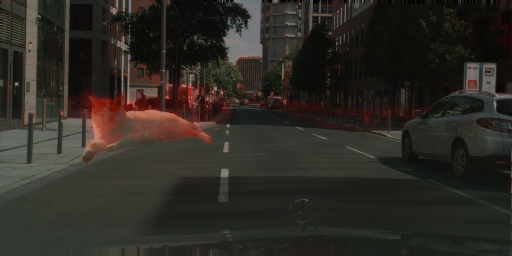

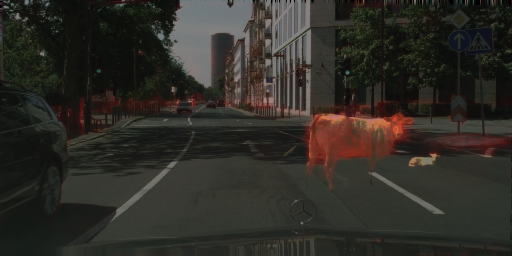

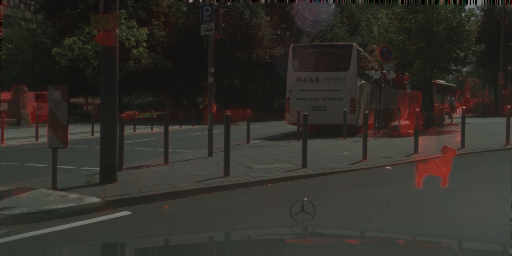

In [475]:
# Going through visualization loader
with torch.no_grad():
    for i, data_i in enumerate(test_loader):
        original = data_i['original'].cuda()
        semantic = data_i['semantic'].cuda()
        synthesis = data_i['synthesis'].cuda()
        label = data_i['label'].cuda()

        # Evaluating
        outputs = softmax(diss_model(original, synthesis, semantic)/3.1)
        (softmax_pred, predictions) = torch.max(outputs, dim=1)
        heatmap = torch.zeros(softmax_pred.shape[0], 3, softmax_pred.shape[1], softmax_pred.shape[2])
        heatmap[:,0,:,:] = outputs[:, 1, :, :]


        original = original.squeeze().cpu()
        heatmap = heatmap.squeeze().cpu()
        
        img = TF.to_pil_image(original) 
        h_img = TF.to_pil_image(heatmap)
        
        res = Image.blend(img, h_img, 0.5)
        display(res)
        if (i+2) > how_many:
            break        

In [462]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

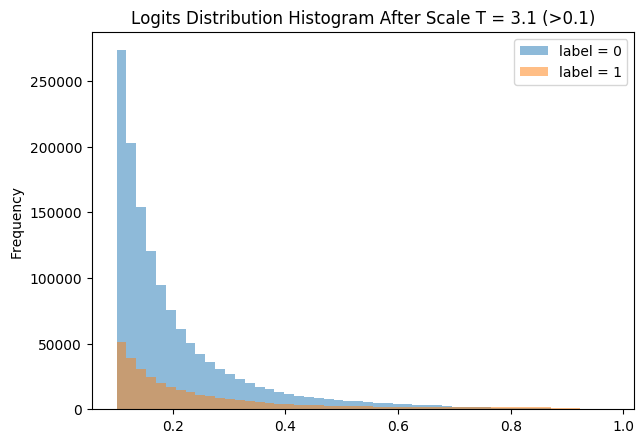

In [464]:

# create memory locations for results to save time while running the code
dataset = cfg_test_loader['dataset_args']
h = int((dataset['crop_size']/dataset['aspect_ratio']))
w = int(dataset['crop_size'])
flat_pred = np.zeros(w*h*len(test_loader), dtype='float32')
flat_labels = np.zeros(w*h*len(test_loader), dtype='float32')

# Going through visualization loader
with torch.no_grad():
    for i, data_i in enumerate(test_loader):
        original = data_i['original'].cuda()
        semantic = data_i['semantic'].cuda()
        synthesis = data_i['synthesis'].cuda()
        label = data_i['label'].cuda()

        # Evaluating
        outputs = softmax(diss_model(original, synthesis, semantic)/3.1)
        (softmax_pred, predictions) = torch.max(outputs, dim=1)
        flat_pred[i*w*h:i*w*h+w*h] = torch.flatten(outputs[:,1,:,:]).detach().cpu().numpy()
        flat_labels[i*w*h:i*w*h+w*h] = torch.flatten(label).detach().cpu().numpy()
        
invalid_indices_void = np.argwhere(flat_labels == 255)
invalid_indices_normal = np.argwhere(flat_labels == 0)
invalid_indices_uncertain = np.argwhere(flat_labels == 1)

flat_pred_zeros = np.delete(flat_pred, invalid_indices_void)
flat_pred_zeros = np.delete(flat_pred, invalid_indices_uncertain)

flat_pred_ones = np.delete(flat_pred, invalid_indices_void)
flat_pred_ones = np.delete(flat_pred, invalid_indices_normal)
   
# Plot Histogram for Labels
plt.hist(flat_pred_zeros[flat_pred_zeros > 0.1], bins=50, alpha=0.5, label='label = 0')
plt.hist(flat_pred_ones[flat_pred_ones>0.1], bins=50, alpha=0.5, label='label = 1')
plt.gca().set(title='Logits Distribution Histogram After Scale T = 3.1 (>0.1)', ylabel='Frequency');
plt.legend(loc='upper right')
plt.show()